# Assessments across interventions

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('tableau-colorblind10')
color='#702A7D'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

In [3]:
query = """
WITH assessment_cat as (SELECT 
  a.person_id
  ,a.AssessmentID
  ,f.category
  ,f.subcategory
FROM
  `CB_2649.tbl_bmbc_Childrens_Social_Services_Assessments` a

LEFT JOIN `CB_2649.cb_FactorLookup` f
ON a.FactorID = f.FactorID)
SELECT ac.person_id
  ,STRING_AGG(distinct ac.category, ', ') AS all_categories
  ,p.gender_source_value as gender
FROM assessment_cat ac
LEFT JOIN yhcr-prd-bradfor-bia-core.CB_2649.person p
on ac.person_id = p.person_id
GROUP BY ac.person_id,p.gender_source_value;
"""

# Load Query into Pandas Dataframe

In [4]:
assessment = pandas_gbq.read_gbq(query)

Downloading: 100%|██████████|


In [5]:
assessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5902 entries, 0 to 5901
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   person_id       5902 non-null   object
 1   all_categories  5902 non-null   object
 2   gender          5899 non-null   object
dtypes: object(3)
memory usage: 138.5+ KB


In [6]:
assessment.head()

,person_id,all_categories,gender
0,5CDE8C6A7B2CB16B6F943015A59FE11ACAB4BB7C1D1034...,"Socially Unacceptable Behaviour, Learning Disa...",1
1,963CC63AFC0B205718057BA30037DEB678B0654AD1DAE5...,Domestic Violence,2
2,97EBB86456C7D933726776B64BFD8976E5CDB2BD4AEBBB...,Domestic Violence,2
3,BC2476193F8D5F34C7F0CA982AAA1C82EE4342B8C717CE...,Domestic Violence,1
4,1659789959EE4F4432C98E7210073767DD1CBC91A7303E...,"Mental Health, Drug Misuse, Other",2


In [21]:
# Number of unique categories
# Split the categories and explode into seperate rows
unique_categories = assessment['all_categories'].str.split(',').explode()

# strip white space and convert to lower case for consistency
unique_categories = unique_categories.str.strip().str.lower()

# Get the unique categories
unique_categories = unique_categories.unique()

# Count the unique categories
number_of_categories = len(unique_categories)

print(f"Total Number of Unique Categories: {number_of_categories}")
print("\nUnique categories:")
print(sorted(unique_categories))

Total Number of Unique Categories: 23

Unique categories:
['abuse linked to faith or belief', 'alcohol misuse', 'child criminal exploitation', 'child sexual exploitation', 'domestic violence', 'drug misuse', 'emotional abuse', 'female genital mutilation', 'gangs', 'learning disability', 'mental health', 'missing', 'neglect', 'other', 'physical abuse', 'physical disability', 'privately fostered', 'self harm', 'sexual abuse', 'socially unacceptable behaviour', 'trafficking', 'uasc', 'young carer']


=== Top 10 Categories by Percentage ===
domestic violence: 14.14%
mental health: 14.1%
emotional abuse: 11.82%
other: 8.12%
drug misuse: 7.45%
neglect: 7.08%
physical abuse: 6.78%
alcohol misuse: 6.06%
learning disability: 4.36%
physical disability: 3.62%


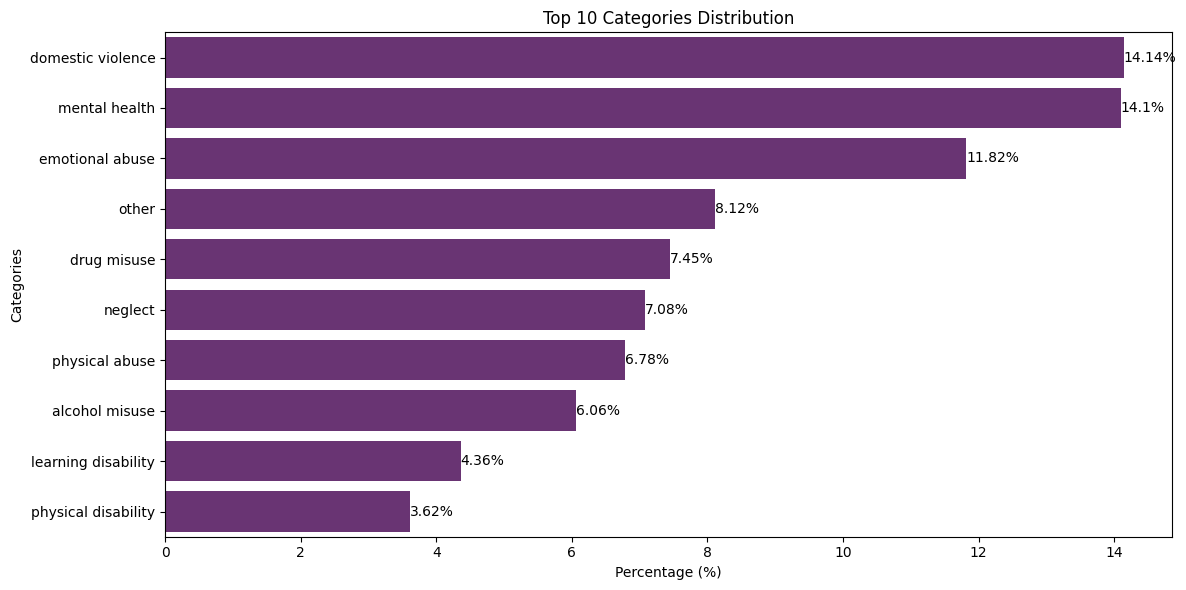

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_category_proportions(df):
    # Split and explode categories
    categories_expanded = df['all_categories'].str.split(',').explode()

    # Clean categories
    categories_expanded = categories_expanded.str.strip().str.lower()

    # Calculate total counts
    total_categories = len(categories_expanded)

    # Calculate proportions
    category_proportions = (categories_expanded.value_counts() / total_categories * 100).round(2)

    # Display top 10 categories with percentages
    print("=== Top 10 Categories by Percentage ===")
    for cat, pct in category_proportions.head(10).items():
        print(f"{cat}: {pct}%")

    # Visualization
    plt.figure(figsize=(12, 6))

    # Create bar plot
    sns.barplot(x=category_proportions.head(10).values,
                y=category_proportions.head(10).index,color=color)

    plt.title('Top 10 Categories Distribution')
    plt.xlabel('Percentage (%)')
    plt.ylabel('Categories')

    # Add percentage labels on bars
    for i, v in enumerate(category_proportions.head(10)):
        plt.text(v, i, f'{v}%', va='center')

    plt.tight_layout()
    plt.show()

    return category_proportions

# Run the analysis
proportions = analyze_category_proportions(assessment)

=== Bottom 10 Categories by Percentage ===
Total number of unique categories: 23

Least common categories:
uasc: 0.08%
female genital mutilation: 0.12%
privately fostered: 0.18%
abuse linked to faith or belief: 0.27%
trafficking: 0.41%
child criminal exploitation: 0.58%
gangs: 1.05%
young carer: 2.01%
self harm: 2.02%
missing: 2.06%


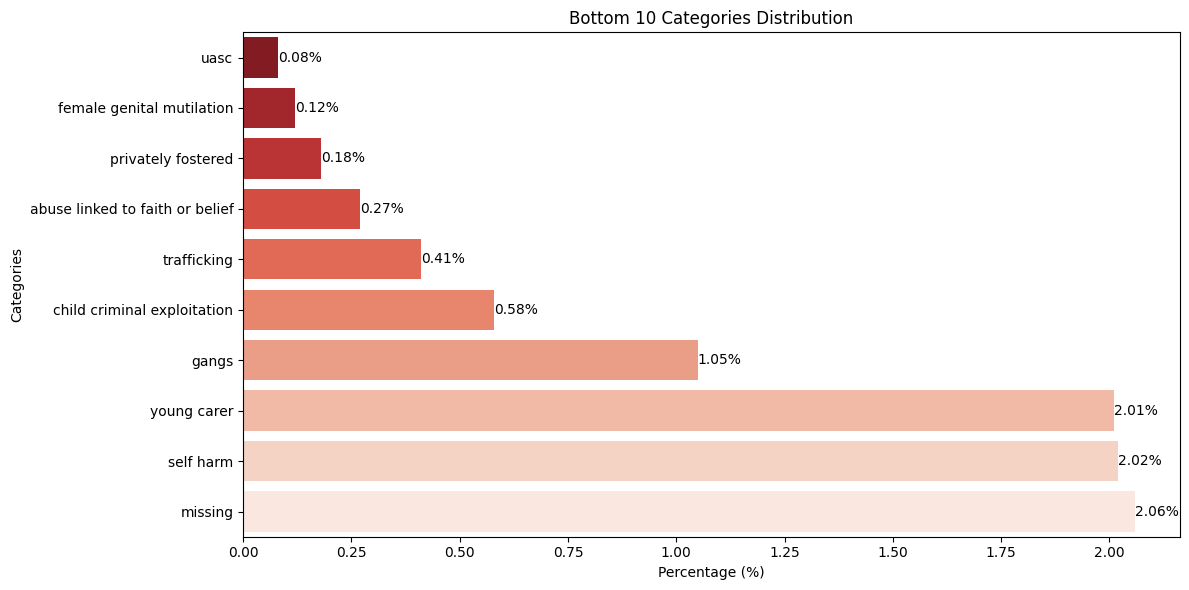

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_bottom_categories(df):
    # Split and explode categories
    categories_expanded = df['all_categories'].str.split(',').explode()

    # Clean categories
    categories_expanded = categories_expanded.str.strip().str.lower()

    # Calculate total counts
    total_categories = len(categories_expanded)

    # Calculate proportions
    category_proportions = (categories_expanded.value_counts() / total_categories * 100).round(2)

    # Get bottom 10 categories
    bottom_10 = category_proportions.nsmallest(10)

    print("=== Bottom 10 Categories by Percentage ===")
    print(f"Total number of unique categories: {len(category_proportions)}")
    print("\nLeast common categories:")
    for cat, pct in bottom_10.items():
        print(f"{cat}: {pct}%")

    # Visualization
    plt.figure(figsize=(12, 6))

    # Create horizontal bar plot for better readability of category names
    sns.barplot(x=bottom_10.values,
                y=bottom_10.index,
                palette='Reds_r')  # Reverse red palette for visual distinction

    plt.title('Bottom 10 Categories Distribution')
    plt.xlabel('Percentage (%)')
    plt.ylabel('Categories')

    # Add percentage labels on bars
    for i, v in enumerate(bottom_10):
        plt.text(v, i, f'{v}%', va='center')

    plt.tight_layout()
    plt.show()

    return bottom_10

# Run the analysis
bottom_proportions = analyze_bottom_categories(assessment)